## Částicové simulace plazmatu

- PIC = *Particle In Cell*
- Patří do kategorie metod molekulární dynamiky, kde je na vývoj polohy částic s časem nahlíženo deterministicky
- Deterministický přístup znamená určit časový vývoj polohy  každé  částice  zkoumaného  systému  v daném časovém kroku
- Výpočetní částice reprezentuje určité množství fyzických částic, které se nacházejí blízko sebe ve fázovém prostoru, tedy platí, že $N_{PIC} \ll N_{\rm particles}$. 

<p style="text-align: center">
    <img src="./Images/interactions.png" width=400px>
    <br>
</p>
Základní myšlenka algoritmu je reprezentace systému relativně malým počtem výpočetních částic, které mají konečnou velikost, které spolu interagují. Částice se tak mohou překrývat (úplně nebo jen částečně). Interakce částic je popsána Coulombovským potenciálem v oblastech, které se nepřekrývají. V malých vzdálenostech je díky překryvu potenciál redukován, čímž se eliminuje efekt, způsobený divergencí potenciálu na krátké vzdálenosti (viz. Figure 4.).

### **Algoritmus metody**
- Plasma je popsáno sadou výpočetních částic o poloze $x_p$, rychlosti $v_p$ , které reprezentují pevně daný počet $N_p$ reálných částic.
- Pro každou výpočetní částici určíme její vývoj z pohybových rovnic pro tuto částici, tedy řešením rovnic

\begin{eqnarray}
x_p^{n+1} = x_p^{n}+\Delta t v_p^{n+1/2} \\
v_p^{n+3/2} = v_p^{n+1/2}+\Delta t \frac{q_s}{m_e}E_p
\end{eqnarray}
  
  přičemž použijeme hodnotu intenzity elektrického pole působícího na výpočetní částici z předchozího kroku.
  
- Hustotu náboje v buňce předem zvolené diskrétní výpočetní sítě spočítáme podle vzorce

\begin{eqnarray}
\rho_i = \sum_p \frac{q_p}{\Delta x}W(x_i-x_p)
\end{eqnarray}
 
 kde $W(x_i-x_p)$ je interpolační funkce a $S_x$ je zvolený tvar distribuční funkce pro po tuto částici. V našem případě 
 $$
 S_x = b_l\left(\frac{x_i-x_p}{\Delta p}\right)
 $$
 $$
 W(x_i-x_p)=\int{S_x(x-x_p)b_0\left(\frac{x-x_i}{\Delta x}\right)}
 $$

- Hodnotu intenzity elektrického pole $E_i$ v bodech sítě určíme řešením Poissonovy rovnice (dostaneme hodnotu potenciálu)

$$
\epsilon_0 \frac{\varphi_{i+1}-2\varphi+\varphi_{i-1}}{\Delta x^2} = \rho_i
$$

 a následně z potenciálu určíme hodnotu intenzity ze vztahu

$$
E_i = -\frac{\varphi_{i+1}-\varphi_{i-1}}{\Delta x}
$$
- Ze známé hodnoty pole výpočetní sítě spočítáme intenzitu elektrického pole působící na výpočetní částici 

\begin{equation}
E_p=\sum_i E_i W(x_i-x_p)
\end{equation}

## Interpolační funkce 

Při matematické formulaci PIC metody se vychází z předpokladu, že distribuční funkce pro každou složku plazmatu (elektrony, protony, ionty) je dána superpozicí několika elementů takzvaných výpočetních částic.

$$
f_s(x,v,t)= \sum_p f_p(x,v,t)
$$
 každý tento element, výpočetní částice reprezentuje předem daný velký počet skutečných částic plazmatu, které se ve fázovém prostoru nachází blízko sebe.
 
 PIC metoda přiřazuje každé výpočetní částici specifickou formu distribuční funkce, funkční formu s volnými parametry, jejíž časový vývoj je určen řešením *Vlasovovy rovnice*. Dále se předpokládá, že je výsledkem tenzorového součinu profilů pro každou souřadnici fázového prostoru
 
 $$
 f_p(x,v,t) = N_p S_x(x-x_p(t))S_v(v-v_p(t))
 $$

kde $S_x,S_v$ jsou profily pro souřadnici $x,v$. Profil musí splňovat určité matematická kriteria, především, že integrál

$$
\int_{-\infty}^{\infty} S_{\xi}(\xi-\xi_p){\rm d}\xi = 1
$$
#### *B-spline funkce*


$$b_0 =\left\{ 
\begin{matrix}
1,\, |\xi|<1/2 \\
0
\end{matrix}
\right.$$

In [2]:
%matplotlib notebook
%matplotlib inline
import scipy.signal as sb
from scipy.constants import *
import numpy as np
import matplotlib.pyplot as plt
from JSAnimation import IPython_display
from matplotlib import animation
from ipywidgets import interact, interactive, fixed, interact_manual

def func_bspline(order,scale):
    x = np.linspace(-3,3,100)
    y = sb.bspline(x/scale,order)
    return x,y
    
def plot_update(order = 1, scale = 1.5):
    x,y = func_bspline(order,scale)
    plt.plot(x,y)
    plt.show()

interact(plot_update,order=(0,5,1),scale=(0.0,1.5,0.01));


interactive(children=(IntSlider(value=1, description='order', max=5), FloatSlider(value=1.5, description='scal…

### Řešení Poissonovy rovnice

Řešení parabolického typu parciálních diferenciálních rovnic jsme si ukázali v předchozích kapitolách. Jen pro připomenutí, diskretizací rovnice podle vhodně zvoleného diferenčního schématu dostaneme soustavu lineárních rovnic pro neznámé hodnoty potenciálu v bodech sítě

\begin{equation*}
\frac{\varphi_{i+1}-2\varphi_{i}+\varphi_{i-1}}{\Delta x}=\frac{\rho_i}{\varepsilon}
\end{equation*}

Matice reprezentující systém lineárních rovnic je tridiagonální, numerické řešení můžeme lehce určit některou z metod uvedenou v předchozích kapitolách nebo použít PYTHON balík [scipy.linalg](https://docs.scipy.org/doc/scipy/reference/linalg.html)

Firstly we need to initialize definition of simulation in term of domain size and of the grid used to discretise it. Firstly, we will set time lapse of simulation together with time step. Next step is to define plasma density. We use normalized units, where the plasma frequency is set to be unitary (althought physicaly unit can be used). Plasma frequency for electrons is given by
\begin{equation}
\omega_{pf} = \sqrt{\frac{n_e q_e^2}{m_e \varepsilon_0}}
\end{equation}
Under the assumption of unity of plasma frequency $\omega_{pf}=1$, unit of charge to mass ratio $qm=\frac{q}{m}=\frac{q_e}{m_e}=1$ (It means charge $q$ to mass $m$ ratio of plasma consisting from electrons inside simulation box). Also in CGS perimitivity of vacuum $\varepsilon \sim 1$. This definition leads to expression

\begin{equation}
\frac{\omega_{pf}^2}{qm} = n_e q_e
\end{equation}

The right side of the equation can be expressed in terms of complete charge of plasma $q$, namely

\begin{equation}
q = n_e q_e L
\end{equation}

so we can rewrite final relation between plasma frequency and charge of plasma as

\begin{equation}
q = \frac{L \omega_{pf}^2}{qm}
\end{equation}

or consequently between plasma frequency and charge of single superparticle

\begin{equation}
q_p = \frac{\omega_{pf}^2}{qm n_p L}
\end{equation}
The ion uniform background density is set exactly to balance the charge of the particles

\begin{equation}
\rho_{back}=-q_p \frac{n_p}{L}
\end{equation}
where charge of the species in the particle is $q_s=q_p/n_s$ (in case of electrons $q_e = q_p/n_e$)

**Debye length**
\begin{align}
\Lambda_D = {\left(\frac{\epsilon_0 K T}{ne^2}\right)}^{1/2}
\end{align}

0.0999


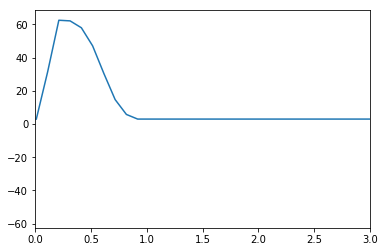

In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.signal as sb
from scipy.constants import *
import matplotlib.pyplot as plt
N = 100
distance = np.linspace(0.01,10,N)
charge = e**2/(4*np.pi*epsilon_0)
force = charge*1.0/distance*1e+28
#plt.plot(distance,force)

dx = 9.99/N
qp = 0.2
print(dx)
scale = 3.0*dx
x = np.array([0.5,9.0])
density_charge = np.zeros(N)
for i,xi in enumerate(np.nditer(distance)):
    density_charge[i] = np.sum(qp/dx*sb.bspline((xi-x)/(scale),1))

b = - density_charge
matrix_data = np.array([np.ones(N), -2.0*np.ones(N),np.ones(N)])
        # Spare tridiagonal matrix creation
A = sp.spdiags(matrix_data, [-1,0,1], N, N).toarray()

potential = np.linalg.solve(A,b)

potential = np.insert(potential,0,potential[0])
potential = np.append(potential,potential[-1])
e_grid = np.zeros(N)
for i in range(N):
    e_grid[i] = (potential[i+1] - potential[i-1])/(2.0*dx)

plt.xlim(0.,3)
plt.plot(distance,e_grid)


### Řešení pohybových rovnic
Pohybové rovnice pro super-částice odvozené z momentů Vlasovy rovnice jsou analogické k pohybovým rovnicím, tak jak je známe z klasické Newtonovy mechaniky.

\begin{align}
\frac{d N_p}{dt}&=0\\
\frac{d x_p}{dt}&=v_p \\
\frac{d v_p}{dt}&=\frac{q_s}{m_s}E_p
\end{align}

Je nutné ovšem zdůraznit, že je zde jeden rozdíl, elektrické pole je v tomto případě dáno průměrem počítaným podle výše uvedeného vzorce (x).

Pohybové rovnice tvoří sadu obyčejných diferenciálnéch rovnic, řešení těchto rovnic budeme hledat numericky. Máme na výběr mnoho různých metod, které jsme si již nastínily v předchozích kaptolách, my však hledáme takové


### Řešení Poissonovy rovnice

Pro řešení soustavy lineárních rovnic použijeme z [SciPy](https://www.scipy.org/) použijeme metodu [https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html](solve) z balíčku linalg. Vzykoušíme ji ne jednoduché soustavě rovnic

Unit test for linear equations solver [numpy.linalg.solve](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html) incorporated in the class Solver() for solution of tridiagonal matrix corresponding to the set of linear equations described by Poisson equations. As a test we used matrix

$
\begin{vmatrix}
        2 & -1 & 0 & 0 & 0 \\
      -1 & 2 & -1 & 0 & 0 \\
      0 & -1 & 2 & -1 & 0 \\
      0 & 0 & -1 & 2 & -1 \\
      0 & 0 & 0 & -1 & 2
\end{vmatrix}
\begin{vmatrix}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
x_5 
\end{vmatrix}
=
\begin{vmatrix}
5 \\
-5 \\
4 \\
-5 \\
5
\end{vmatrix}
$

In [3]:
#Testing of linear equation solver
N = 5
matrix_data = np.array([np.ones(N), -2.0*np.ones(N),np.ones(N)])
        # Spare tridiagonal matrix creation
A = sp.spdiags(matrix_data, [-1,0,1], N, N).toarray()
b = np.array([5,-5,4,-5,5])
result = np.linalg.solve(A,b)
print('Result of linear set equations',np.dot(result,A))

Result of linear set equations [ 5. -5.  4. -5.  5.]


## Simulation of two stream plasma instability

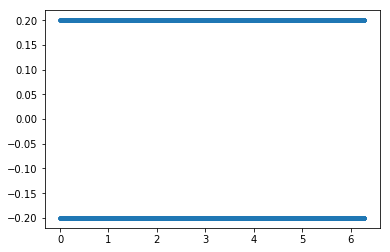

In [4]:
%matplotlib inline
import matplotlib.pylab as plt

import pic
p = pic.Superparticles(0.0,1.0,1.0,0.5)
solvepic = pic.Solver(0.5)
solvepic.create_particles()
solvepic.initial_conditions()
plt.plot(solvepic.particles.positions,solvepic.particles.velocities,'.')

In [5]:
t = 0
for i in range(10):
    solvepic.update_particlesposition()
    solvepic.boundary_limits()
    solvepic.density_on_grid()
    solvepic.rightside_vector()
    solvepic.poisson_equation()
    solvepic.electric_field_on_grid()
    solvepic.update_particlesforce()
    solvepic.update_particlesvelocity()
    t = t+solvepic.dt


<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=None, filternorm=1, filterrad=4.0, imlim=None, resample=None, url=None, *, data=None, **kwargs)>

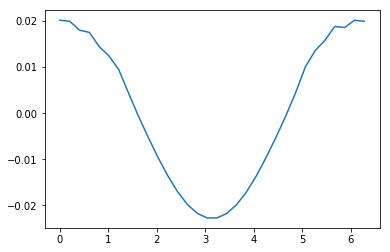

In [6]:
np.set_printoptions(precision=3,suppress=True)
w = np.zeros(solvepic.configuration["points"])
for i,x in enumerate(solvepic.grid_x):
    w[i] = np.sum(solvepic._shape(x,solvepic.particles.positions))

plt.plot(solvepic.grid_x,solvepic.grid_density,'-')
plt.imshow

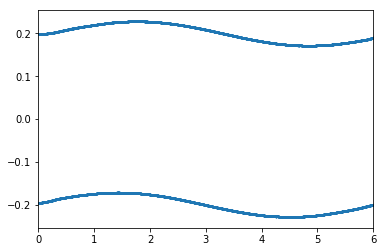

In [7]:
plt.xlim(0,6)
plt.scatter(solvepic.particles.positions,solvepic.particles.velocities,s=1)

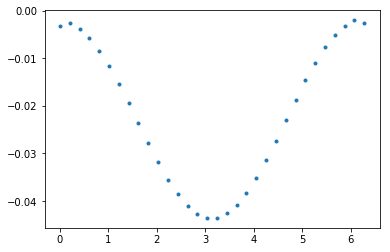

In [8]:
plt.plot(solvepic.grid_x,solvepic.potential,'.')

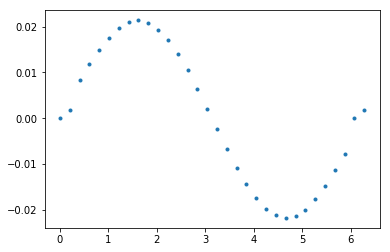

In [9]:
plt.plot(solvepic.grid_x,solvepic.grid_efield,'.')

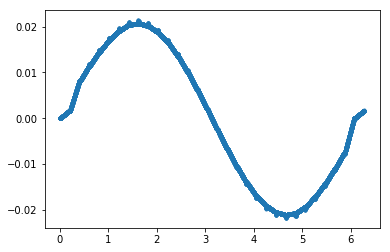

In [10]:
plt.plot(solvepic.particles.positions,solvepic.particles.forces,'.')

Populating the interactive namespace from numpy and matplotlib


C:\Users\PC\.conda\envs\Lectures\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['find', 'interactive', 'e', 'plt', 'pi', 'bar']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"



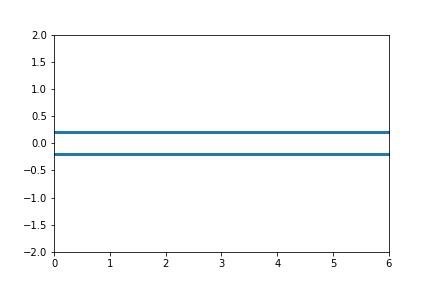
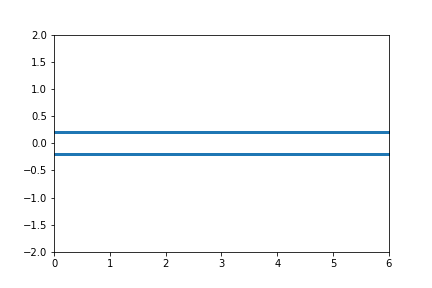
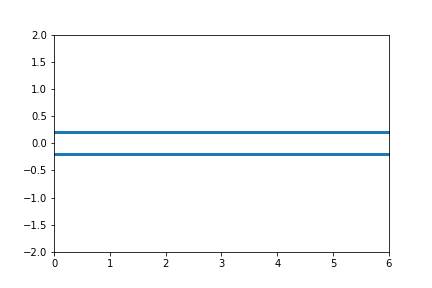
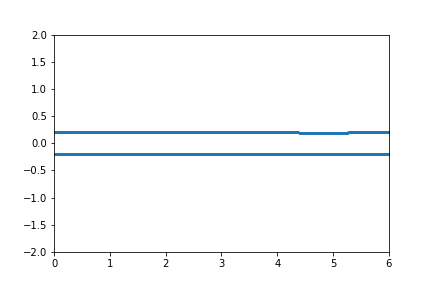
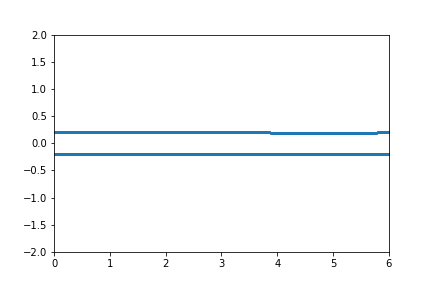
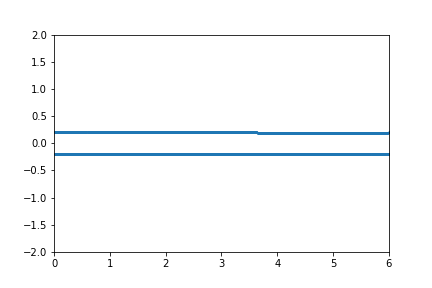
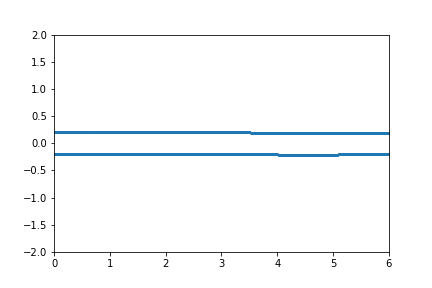
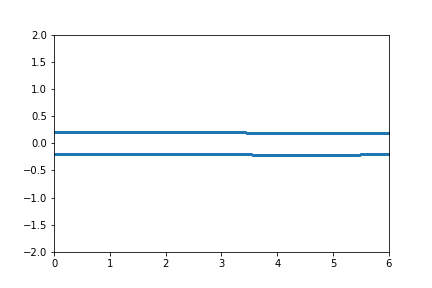
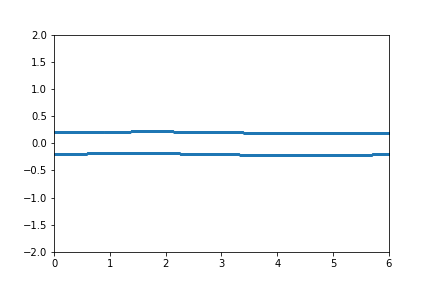
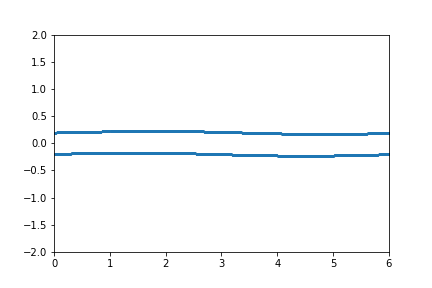
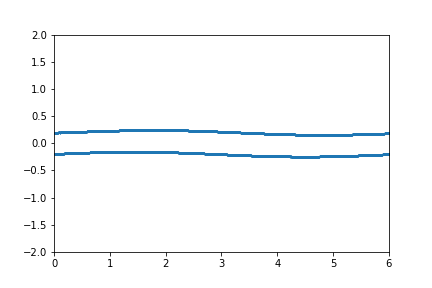
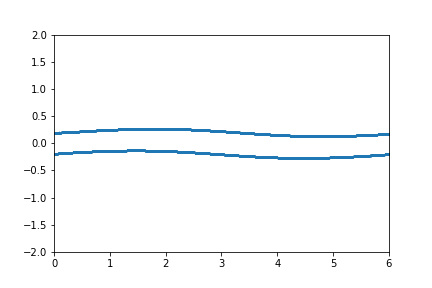
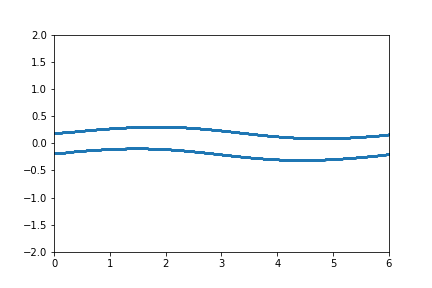
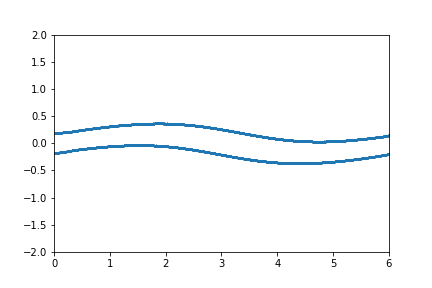
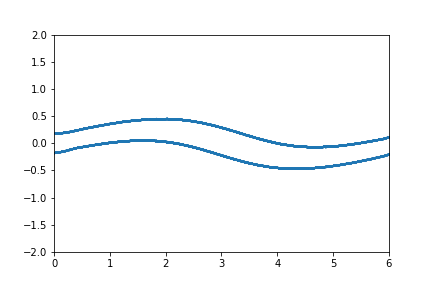
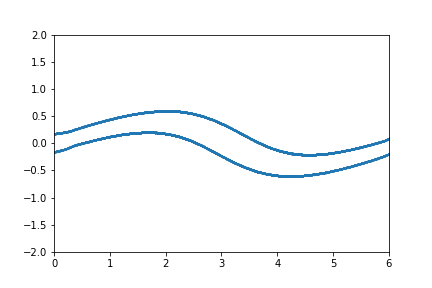
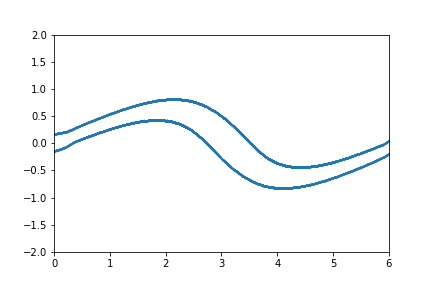
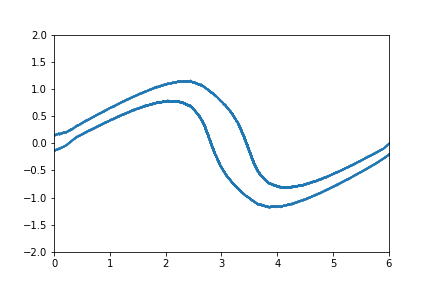
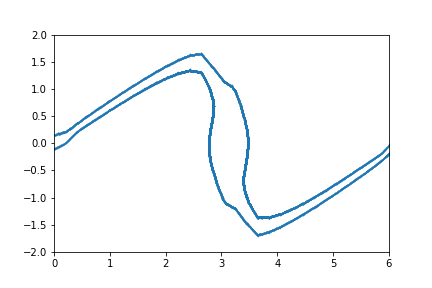
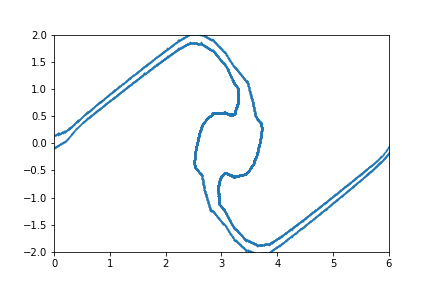
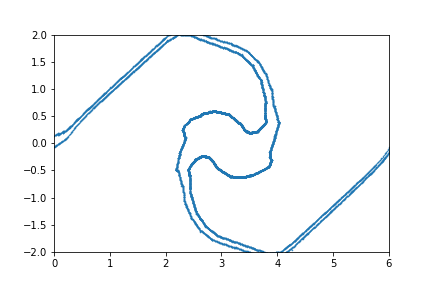
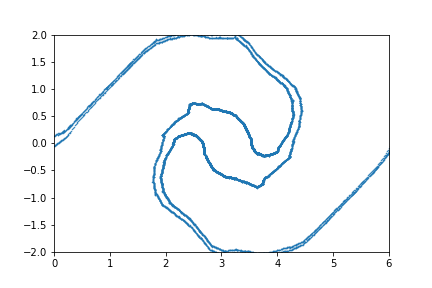
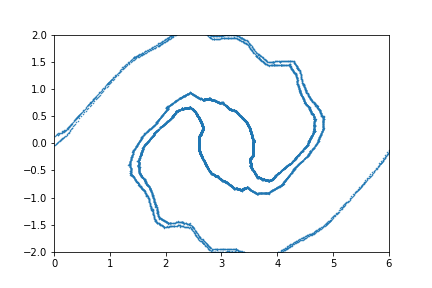
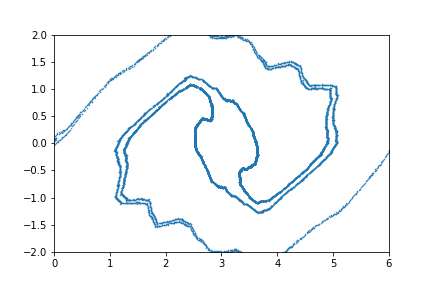
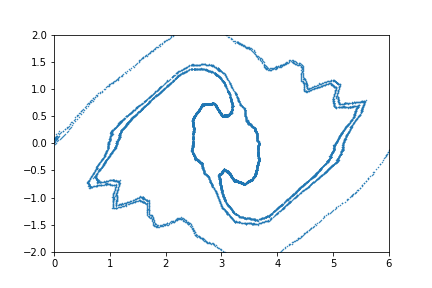
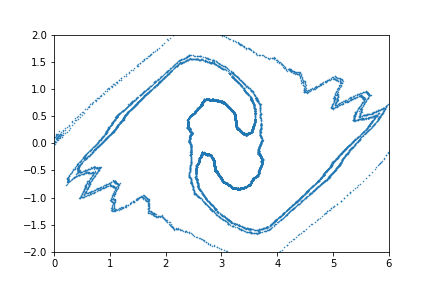
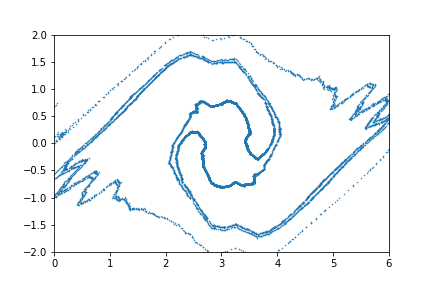
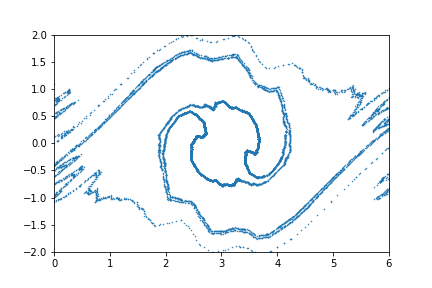
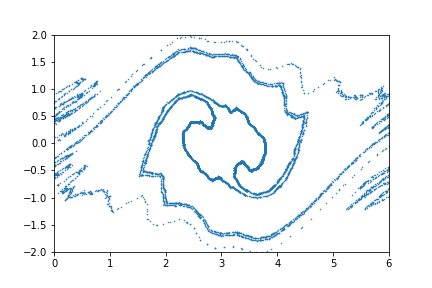
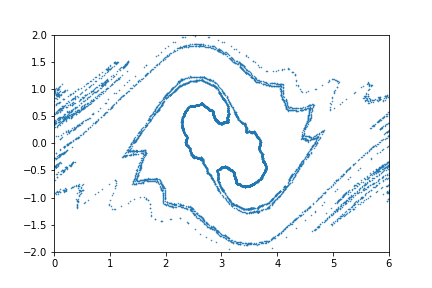
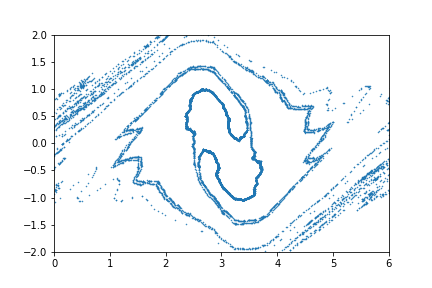
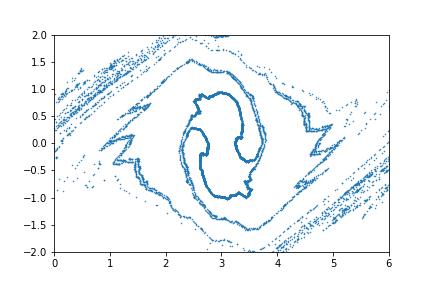
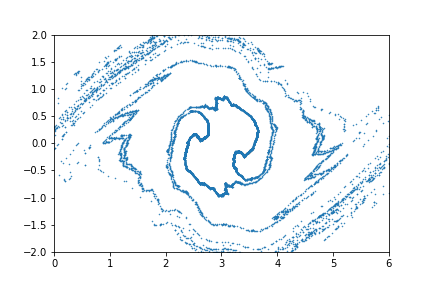
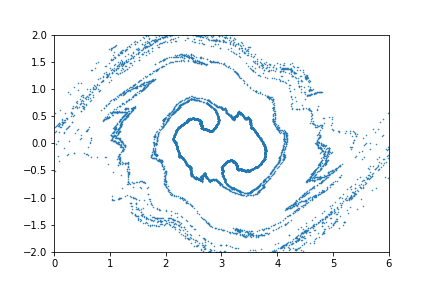
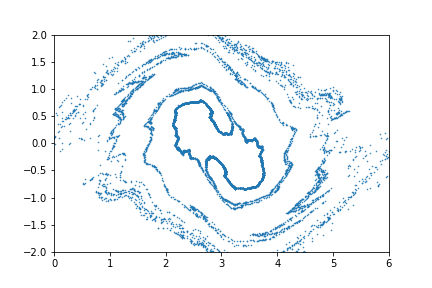
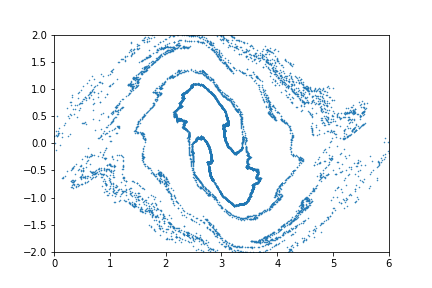
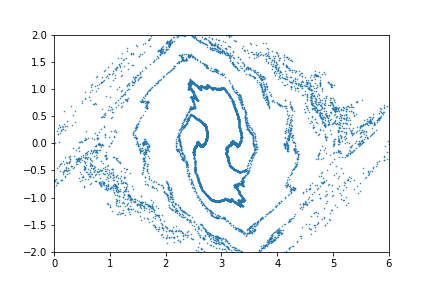
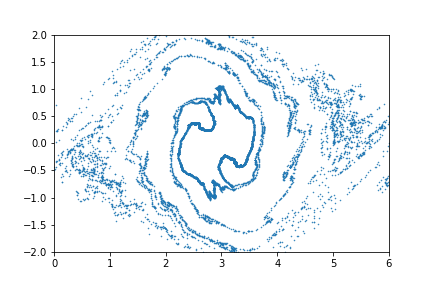
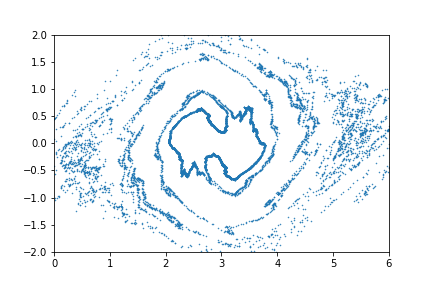
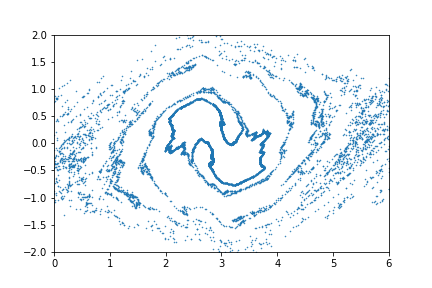
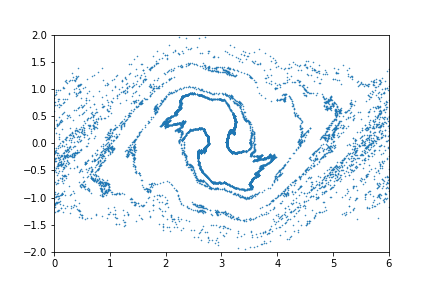
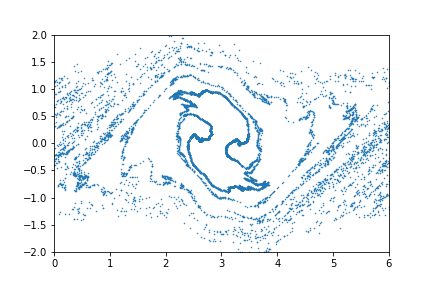
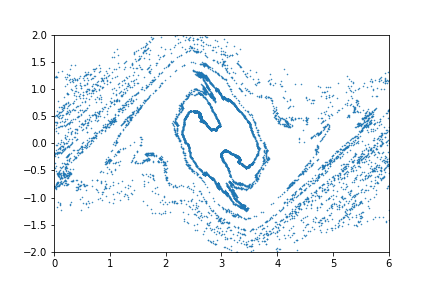
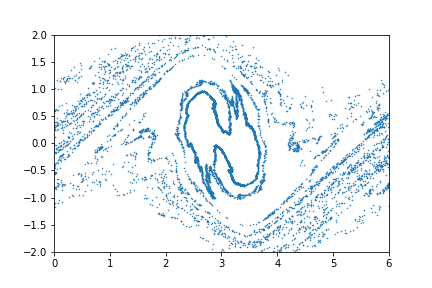
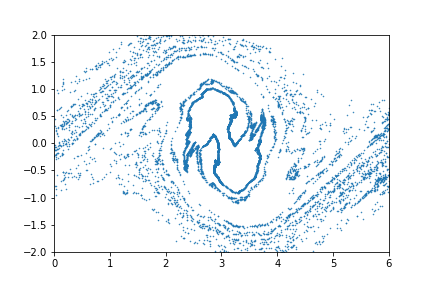
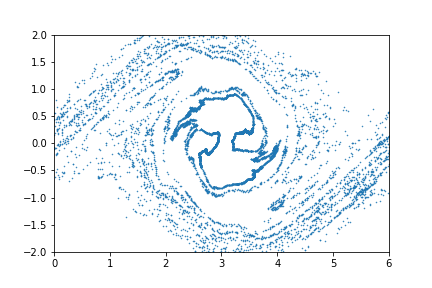
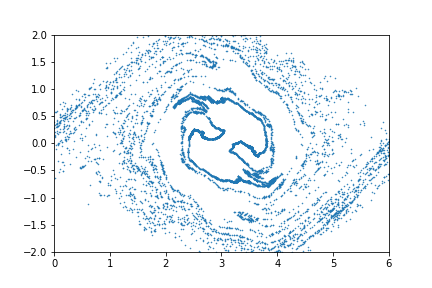
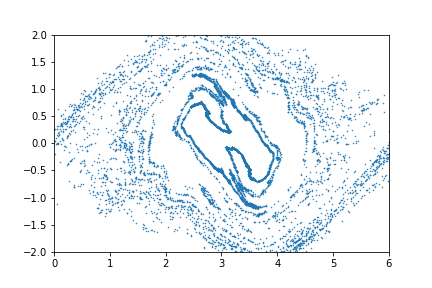
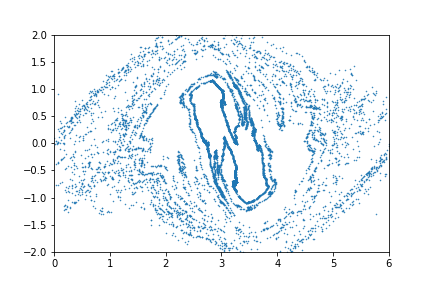
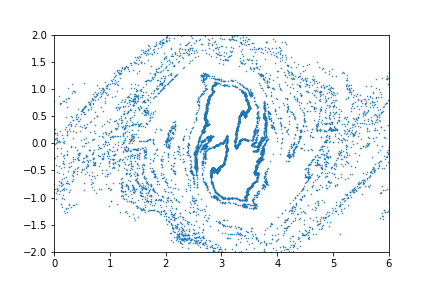
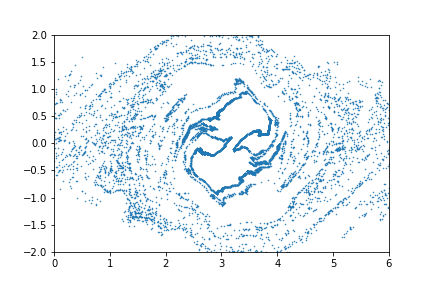
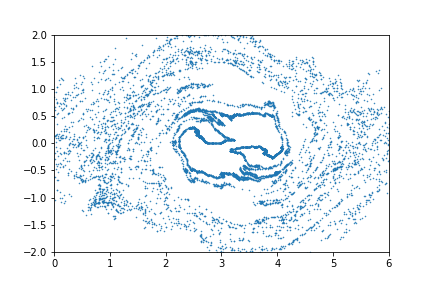
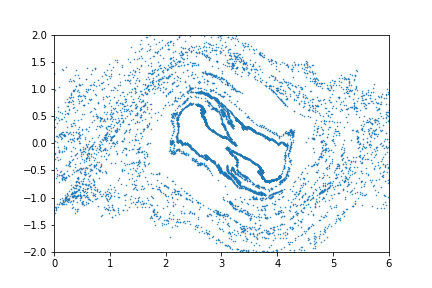
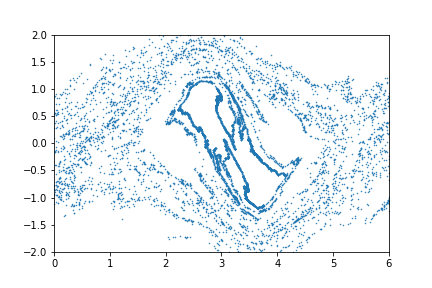
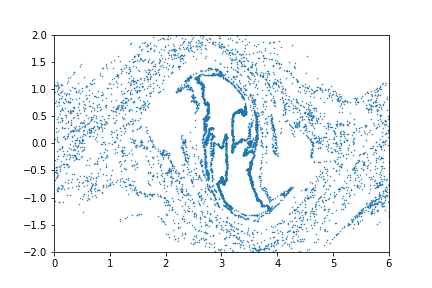
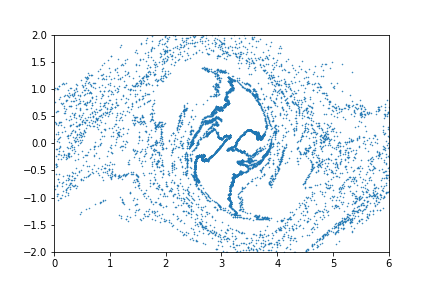
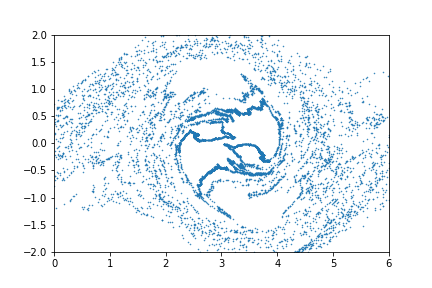
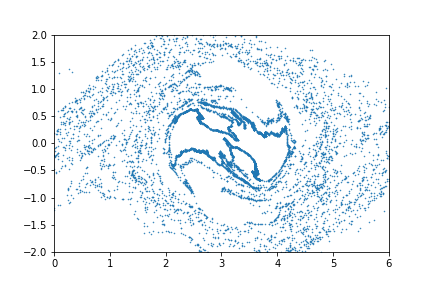
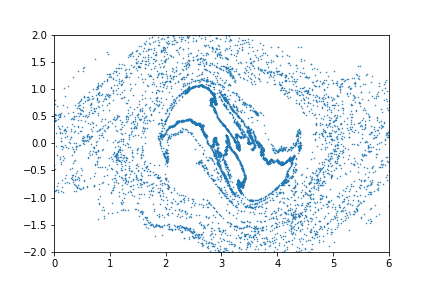
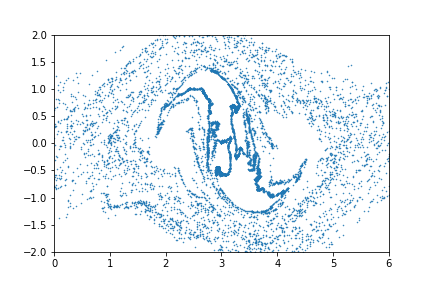
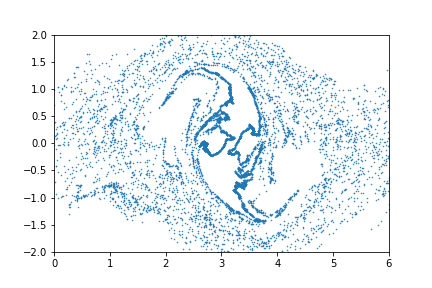
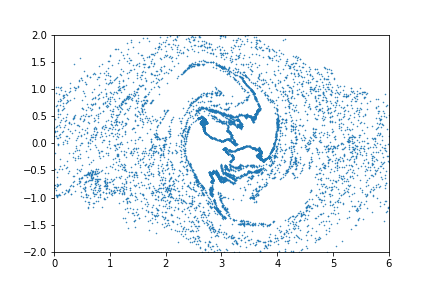
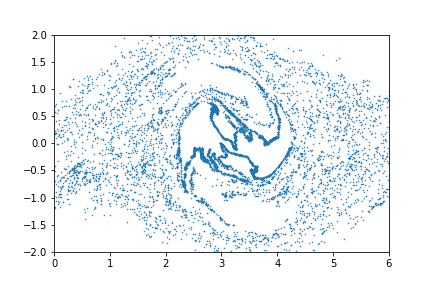
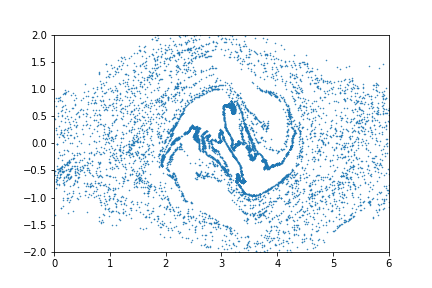
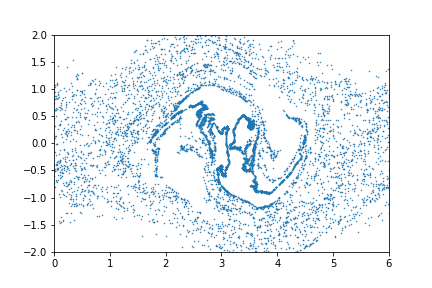
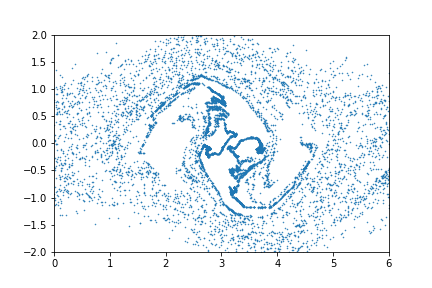
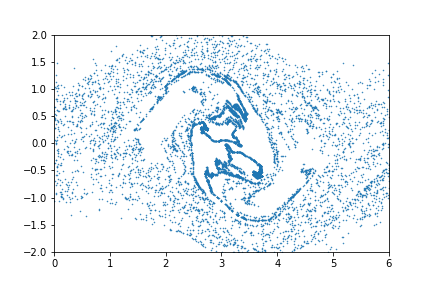
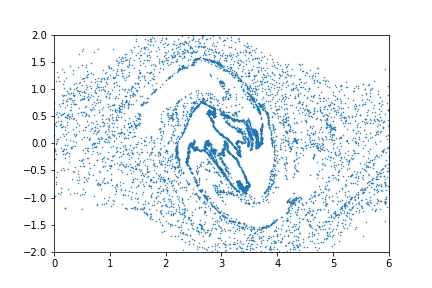
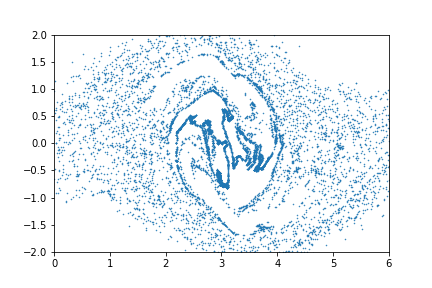
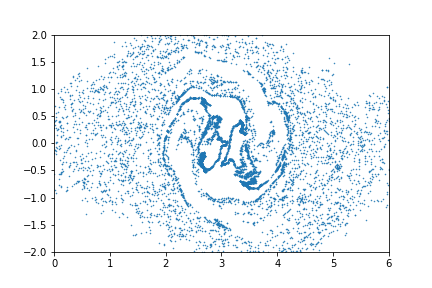
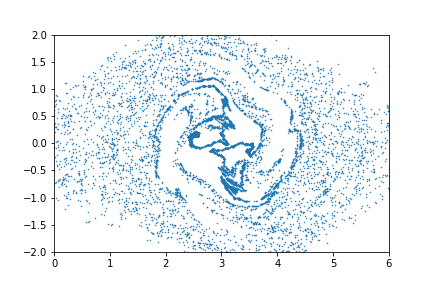
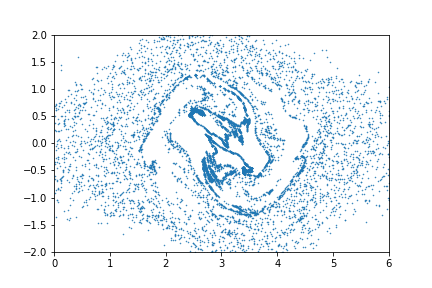
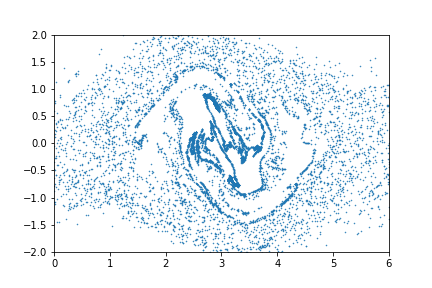
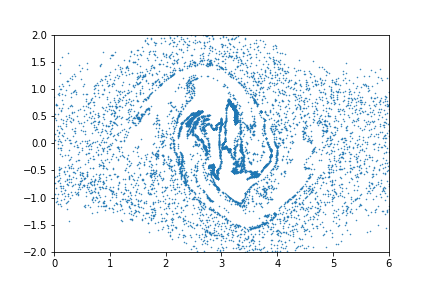
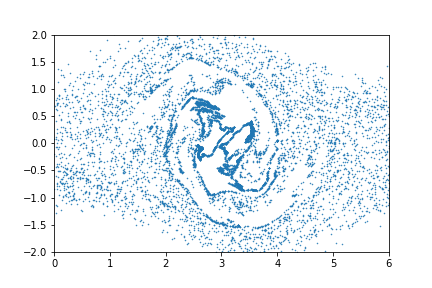
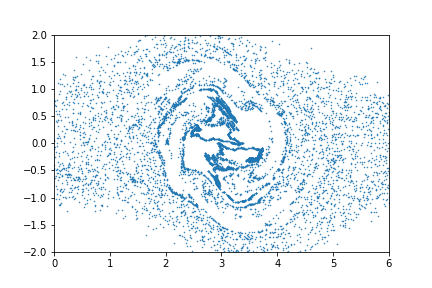
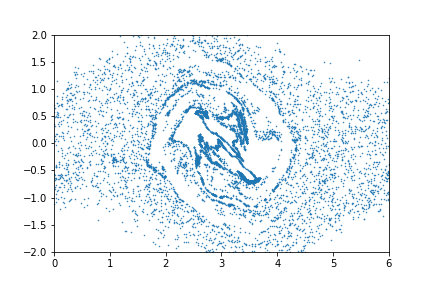
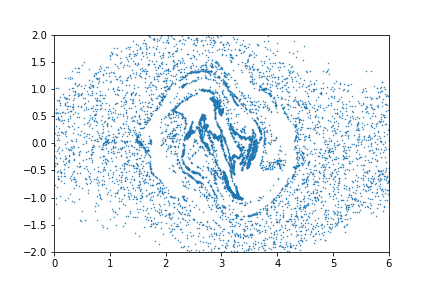
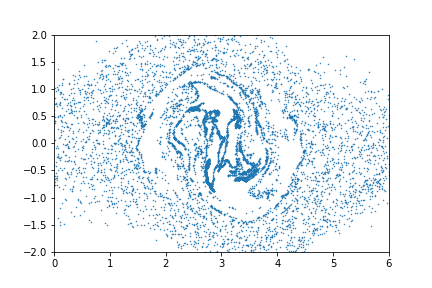
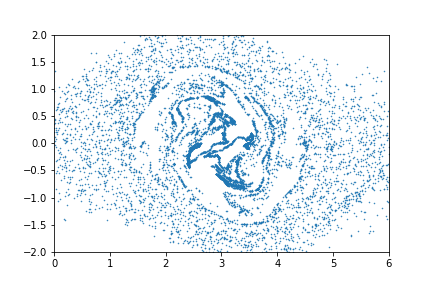
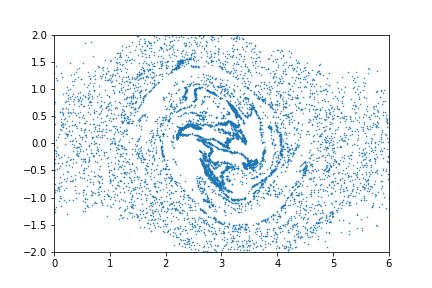
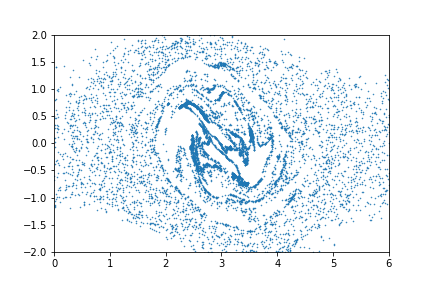
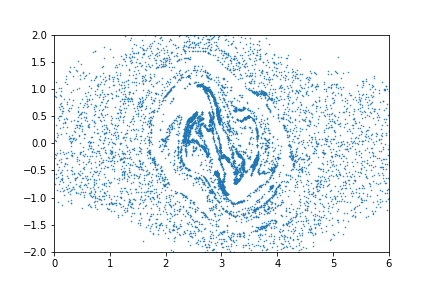
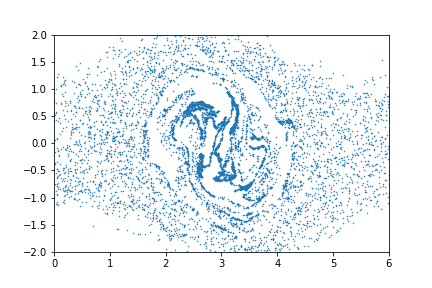
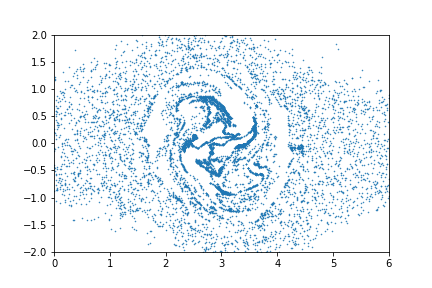
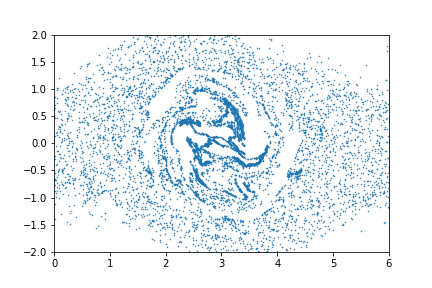
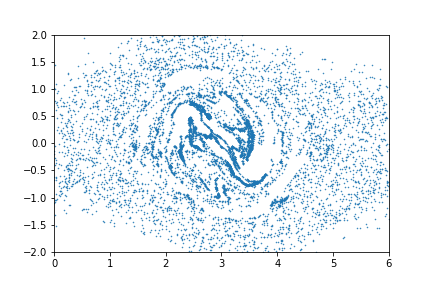
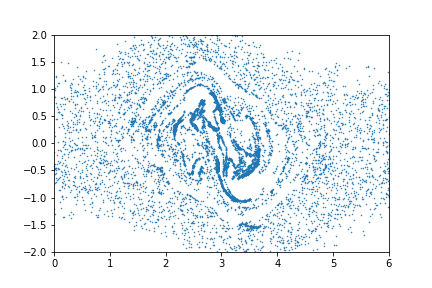
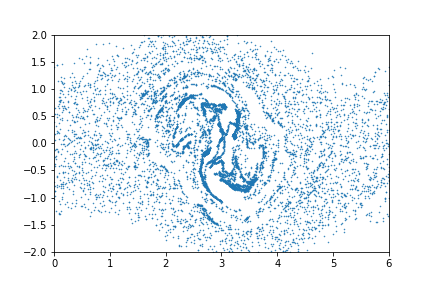
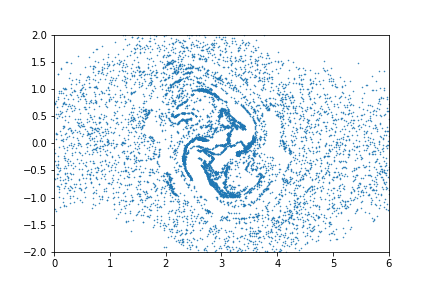
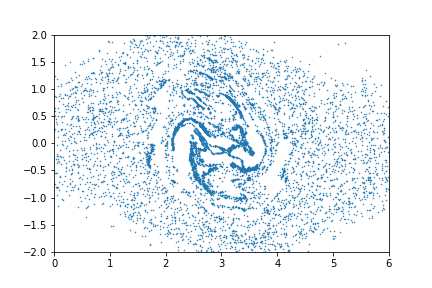
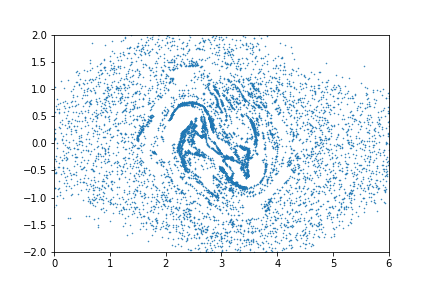
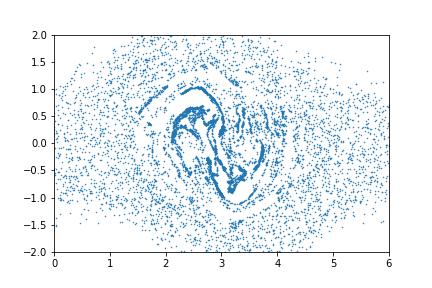
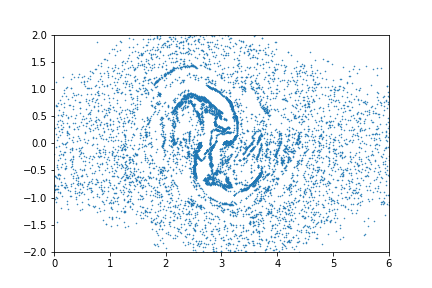
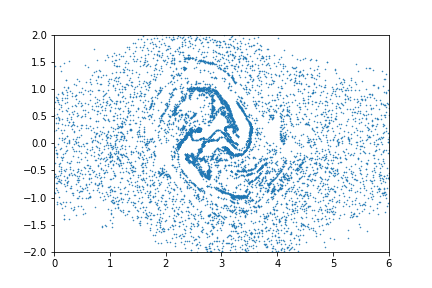
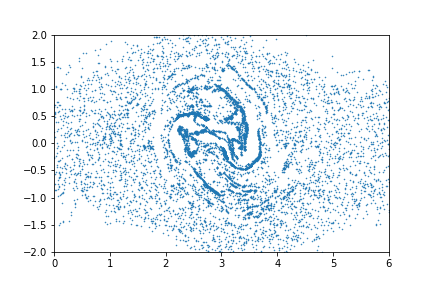
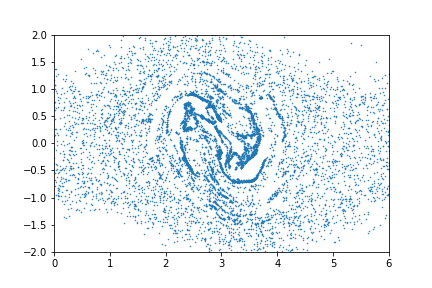
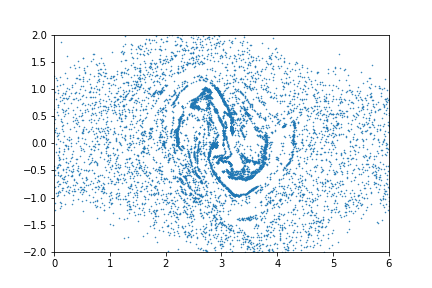
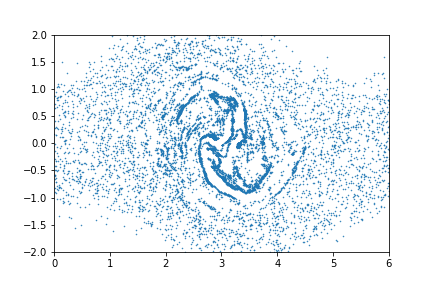
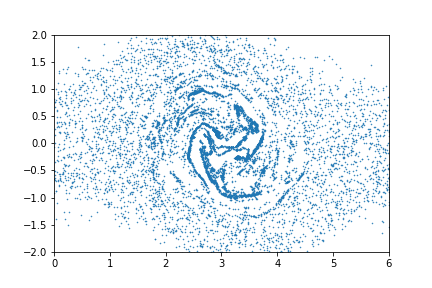

In [11]:
import pic

solvepic = pic.Solver(0.5)
solvepic.create_particles()
solvepic.initial_conditions()

# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation

# create a simple animation
fig = plt.figure()
ax = plt.axes(xlim=(0, 6), ylim=(-2, 2))
line, = ax.plot([], [], '.', markersize=1)

def init():
    line.set_data([], [])
    return line,

t0=0.0

def animate(i):
    solvepic.update_particlesposition()
    solvepic.boundary_limits()
    solvepic.density_on_grid()
    solvepic.rightside_vector()
    solvepic.poisson_equation()
    solvepic.electric_field_on_grid()
    solvepic.update_particlesforce()
    solvepic.update_particlesvelocity()
    line.set_data(solvepic.particles.positions,solvepic.particles.velocities)
    t = t0+solvepic.dt*i
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=100, interval=100, blit=True)
